In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, MetaData
from sqlalchemy import Column, Integer, String, Float
from sqlalchemy.ext.declarative import declarative_base

engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [ ]:
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

In [3]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)


# reflect the tables

In [4]:
# We can view all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [5]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [6]:
# Create our session (link) from Python to the DB
session = Session(engine)


In [ ]:
all_measurements_query = session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs)
all_measurements_df = pd.DataFrame(all_measurements_query, columns=['id', 'station', 'date', 'prcp', 'tobs'])
all_measurements_df.to_csv('all_measurements.csv')

all_stations_query = session.query(Station.id, Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation)
all_stations_df = pd.DataFrame(all_stations_query, columns=['id', 'station', 'name', 'latitude', 'longitude', 'elevation'])
all_stations_df.to_csv('all_stations.csv')

meas_stations_df = all_measurements_df.merge(all_stations_df, on='station')

meas_stations_df['station'].count()

# Exploratory Climate Analysis

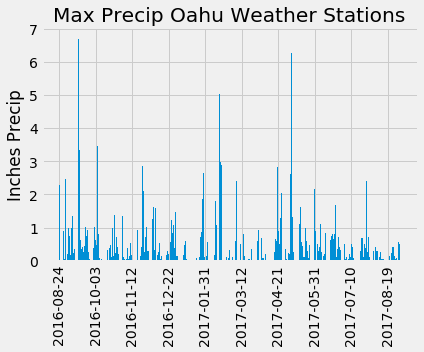

In [23]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

earliest_date_query = session.query(Measurement.date).order_by(Measurement.date).first()
latest_date_query = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
ed_dict=earliest_date_query._asdict()
earliest_date = ed_dict['date']
ld_dict=latest_date_query._asdict()
latest_date = ld_dict['date']

earliest_date_dt = dt.datetime.strptime(earliest_date, "%Y-%m-%d")
latest_date_dt = dt.datetime.strptime(latest_date, "%Y-%m-%d")

# Calculate the date 1 year ago from the last data point in the database
year_ago_latest_dt = latest_date_dt - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
date_prcp_query = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date<=latest_date_dt).filter(Measurement.date>=year_ago_latest_dt)

# Save the query results as a Pandas DataFrame and set the index to the date column
date_prcp_df = pd.DataFrame(date_prcp_query, columns=['Date', 'Precipitation'])
date_prcp_df.set_index('Date', inplace=True)
date_prcp_df.to_csv('date_prcp.csv')

# Sort the dataframe by date
date_prcp_df.dropna(inplace=True)
date_prcp_df.sort_index(inplace=True)
date_prcp_max = date_prcp_df.groupby('Date')[['Precipitation']].max()



# Use Pandas Plotting with Matplotlib to plot the data
x = date_prcp_max.index
y = date_prcp_max['Precipitation']

fig, ax = plt.subplots()
ax.bar(x, y)
ax.set_xticks(x[::39])
ax.set_xticklabels(x[::40], rotation=90)
plt.ylabel('Inches Precip')
plt.title('Max Precip Oahu Weather Stations')
plt.show()


In [28]:
# Use Pandas to calcualte the summary statistics for the precipitation data
print(date_prcp_max.describe())

Precipitation
count     365.000000
mean        0.517288
std         0.829196
min         0.000000
25%         0.040000
50%         0.250000
75%         0.650000
max         6.700000


In [ ]:
# Design a query to show how many stations are available in this dataset?


In [ ]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.


In [ ]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?


In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
